In [1]:
import pandas as pd
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
#input data
def input_data(folder):
    cv = pd.read_csv(folder+'/' + folder + '_video_result.csv')
    cv['pupil'] = pd.to_numeric(cv['pupil'], errors='coerce')
    cv['ratio'] = pd.to_numeric(cv['ratio'], errors='coerce')
    cv['x'] = pd.to_numeric(cv['x'], errors='coerce')
    cv['y'] = pd.to_numeric(cv['y'], errors='coerce')
    cv['ts'] = pd.to_numeric(cv['ts'], errors='coerce')
    cv['ts'] = np.around(cv['ts'], decimals=0)
    #seperate by steps
    cv = cv[cv['pupil'] != 0] #remove zeros
    s30_cv = cv[cv['step'] == 30]
    s31_cv = cv[cv['step'] == 31]
    s32_cv = cv[cv['step'] == 32]
    return cv, s30_cv, s31_cv, s32_cv

In [3]:
from collections import OrderedDict
def get_quartiles(arr):
    arr = [i for i in arr if not np.isnan(i)]
    arr = np.sort(arr)
    mid = int(len(arr)/2)
    if(len(arr)%2 == 0):
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    else:
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    return Q1,Q3

def eliminate_outliers(values, bias = 1.5):
    q1,q3 = get_quartiles(values)
    iqr = q3 - q1
    lowerLimit = np.around(q1 - bias*iqr, decimals=2)
    upperLimit = np.around(q3 + bias*iqr, decimals=2)

    print('IQR', iqr, 'lower', lowerLimit, 'Q1', q1, 'Q3', q3, 'upper', upperLimit)
    result = []
    for v in values:
        if v < lowerLimit or v > upperLimit: 
            result.append(0)
        else:
            result.append(v)
            
    print('remove ratio ', 1-(len([i for i in result if i != 0])/len(values)), '\n')
    return result

In [4]:
from statsmodels.stats.stattools import medcouple
import math
def adjust_boxplot(values, bias=1.5):
    mc = np.around(medcouple(values), decimals=1)
    print('**medcouple', mc)
    
    if mc == 0:
        result = eliminate_outliers(values, bias)
    else:
        q1,q3 = get_quartiles(values)
        iqr = q3 - q1
        if mc > 0:
            lowerLimit = np.around(q1 - bias*math.exp(-3.5*mc)*iqr, decimals=2)
            upperLimit = np.around(q3 + bias*math.exp(4*mc)*iqr, decimals=2)
        else:
            lowerLimit = np.around(q1 - bias*math.exp(-4*mc)*iqr, decimals=2)
            upperLimit = np.around(q3 + bias*math.exp(3.5*mc)*iqr, decimals=2)
        
        print('IQR', iqr, 'lower', lowerLimit, 'Q1', q1, 'Q3', q3, 'upper', upperLimit)
        result = []
        for v in values:
            if v < lowerLimit or v > upperLimit: 
                result.append(0)
            else:
                result.append(v)
                
        print('remove ratio ', 1-(len([i for i in result if i != 0])/len(values)), '\n')
    return result

In [5]:
def remove_outliers(df, param, bias=1.5):
#     values = eliminate_outliers(list(df[param]), bias)
    
    ad_value = adjust_boxplot(list(df[param]), bias)
    
    df[param] = ad_value
    df = df[df[param] != 0]
    
    return df

# remove_by_ratio(s30_changes_cv_left)
# remove_by_ratio(s30_changes_cv_right)

In [6]:
def run(step_cv_df):
    ## before clean data
    changes_cv_left = step_cv_df[step_cv_df['side'] == 'L'] #select individual side
    changes_cv_right = step_cv_df[step_cv_df['side'] == 'R']
    
    #two plot shows the same axis range
    x_upper = max(step_cv_df['x'])+10
    x_lower = min(step_cv_df['x'])-10
    
    y_upper = max(step_cv_df['y'])+10
    y_lower = min(step_cv_df['y'])-10
       
    p_upper = max(step_cv_df['pupil'])+5
    p_lower = min(step_cv_df['pupil'])-5
    
    #plot cv coordinate
    _, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 6), sharex=True)
    ax1.scatter(x=changes_cv_left['ts'], y=list(changes_cv_left['x']), label='left x', s=5)
    ax1.scatter(x=changes_cv_right['ts'], y=list(changes_cv_right['x']), label='right x', s=5)
    ax2.scatter(x=changes_cv_left['ts'], y=list(changes_cv_left['y']), label='left y', s=5)
    ax2.scatter(x=changes_cv_right['ts'], y=list(changes_cv_right['y']), label='right y', s=5)
    ax3.scatter(x=changes_cv_left['ts'], y=list(changes_cv_left['pupil']), label='left pupil', s=5)
    ax3.scatter(x=changes_cv_right['ts'], y=list(changes_cv_right['pupil']), label='right pupil', s=5)
    
    ax1.set_ylim(x_lower, x_upper)
    ax2.set_ylim(y_lower, y_upper)
    ax3.set_ylim(p_lower, p_upper)
    
    ax3.grid()
    ax2.grid()
    ax1.set_title('cv (x,y) scatter before')
    ax2.legend(loc='best')
    ax1.grid()
    ax1.legend(loc='best')
    ax3.legend(loc='best')
#     plt.savefig(save_file+'_cv_coord_calib.png', dpi=100)
    plt.show()
    
    
    before_size = len(list(step_cv_df['pupil']))
    
    ## after clean data
    step_cv_df = remove_outliers(step_cv_df, 'pupil')
    step_cv_df = remove_outliers(step_cv_df, 'y', 3)
    step_cv_df = remove_outliers(step_cv_df, 'x', 3)
    
    print('after clean data, remove ratio', 1-(len(list(step_cv_df['pupil']))/before_size))
    
    changes_cv_left = step_cv_df[step_cv_df['side'] == 'L'] #select individual side
    changes_cv_right = step_cv_df[step_cv_df['side'] == 'R']

    #plot cv coordinate
    _, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 6), sharex=True)
    ax1.scatter(x=changes_cv_left['ts'], y=list(changes_cv_left['x']), label='left x', s=5)
    ax1.scatter(x=changes_cv_right['ts'], y=list(changes_cv_right['x']), label='right x', s=5)
    ax2.scatter(x=changes_cv_left['ts'], y=list(changes_cv_left['y']), label='left y', s=5)
    ax2.scatter(x=changes_cv_right['ts'], y=list(changes_cv_right['y']), label='right y', s=5)
    ax3.scatter(x=changes_cv_left['ts'], y=list(changes_cv_left['pupil']), label='left pupil', s=5)
    ax3.scatter(x=changes_cv_right['ts'], y=list(changes_cv_right['pupil']), label='right pupil', s=5)
    
    ax1.set_ylim(x_lower, x_upper)
    ax2.set_ylim(y_lower, y_upper)
    ax3.set_ylim(p_lower, p_upper)
    
    ax3.grid()
    ax2.grid()
    ax1.set_title('cv (x,y) scatter after')
    ax2.legend(loc='best')
    ax1.grid()
    ax1.legend(loc='best')
    ax3.legend(loc='best')
#     plt.savefig(save_file+'_cv_coord_calib.png', dpi=100)
    plt.show()
    
    # clean data
#     changes_cv_left = remove_by_ratio(changes_cv_left)
#     changes_cv_right = remove_by_ratio(changes_cv_right)
#     changes_cv_left = remove_by_coordinate(changes_cv_left, 'y')
#     changes_cv_right = remove_by_coordinate(changes_cv_right, 'y')
    

In [19]:
s30_cv36.head(10)


,step,ts,x,y,pupil,ratio,sim,side,d2
0,30,100.0,109.0,7.0,16.00,0.33,29.42,L,-1.00
1,30,133.0,157.0,84.0,16.00,0.33,30.25,L,-1.00
2,30,167.0,108.0,11.0,16.00,0.33,27.86,L,-1.00
3,30,200.0,106.0,15.0,20.00,0.42,26.94,L,-1.00
4,30,233.0,140.5,24.0,14.25,0.31,16.65,R,-1.00
5,30,400.0,96.0,35.0,20.00,0.35,9.58,L,-1.00
6,30,433.0,147.0,31.5,16.75,0.31,5.94,L,-1.00
7,30,500.0,145.5,30.5,16.50,0.31,6.86,L,68.31
8,30,500.0,81.0,53.0,23.00,0.46,20.29,R,68.31
9,30,533.0,145.5,29.5,16.50,0.32,7.43,L,-1.00


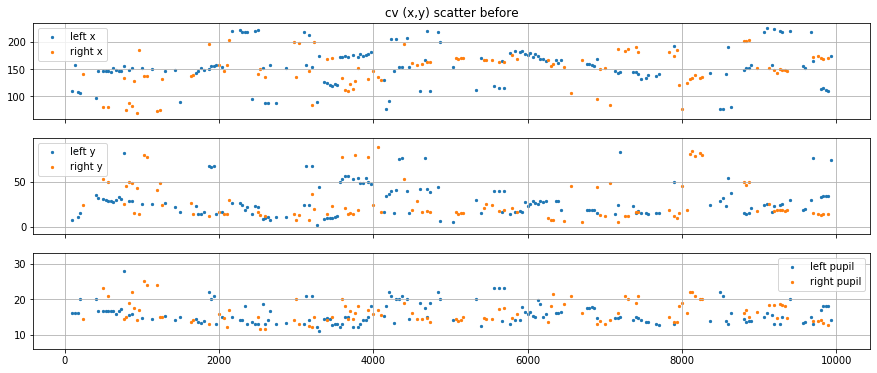

**medcouple 0.4
IQR 4.0 lower 12.52 Q1 14.0 Q3 18.0 upper 47.72
remove ratio  0.04347826086956519 

**medcouple 0.3
IQR 22.0 lower -8.1 Q1 15.0 Q3 37.0 upper 256.13
remove ratio  0.0 

**medcouple 0.1
IQR 38.5 lower 52.61 Q1 134.0 Q3 172.5 upper 344.81
remove ratio  0.0 

after clean data, remove ratio 0.04347826086956519


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


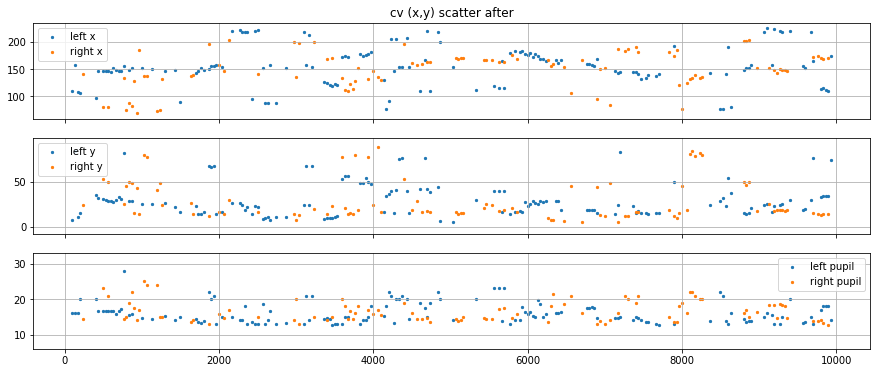

In [7]:
cv_36, s30_cv36, s31_cv36, s32_cv36 = input_data('train36')
run(s30_cv36)

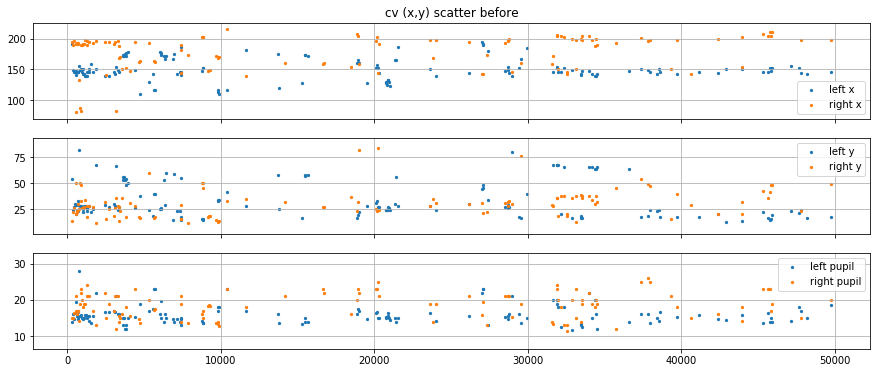

**medcouple 0.3
IQR 4.25 lower 12.52 Q1 14.75 Q3 19.0 upper 40.17
remove ratio  0.03448275862068961 

**medcouple 0.3
IQR 15.25 lower 5.99 Q1 22.0 Q3 37.25 upper 189.15
remove ratio  0.0 

**medcouple 0.5
IQR 47.0 lower 120.5 Q1 145.0 Q3 192.0 upper 1233.86
remove ratio  0.03968253968253965 

after clean data, remove ratio 0.07279693486590033


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


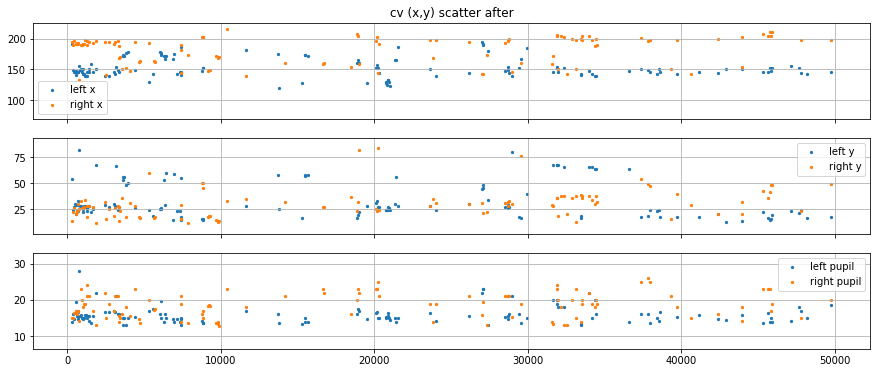

In [18]:
select = cv_36[cv_36['d2'] > 20]
select = select[select['sim'] <= 20]
select_30 = select[select['step'] == 30]
run(select)

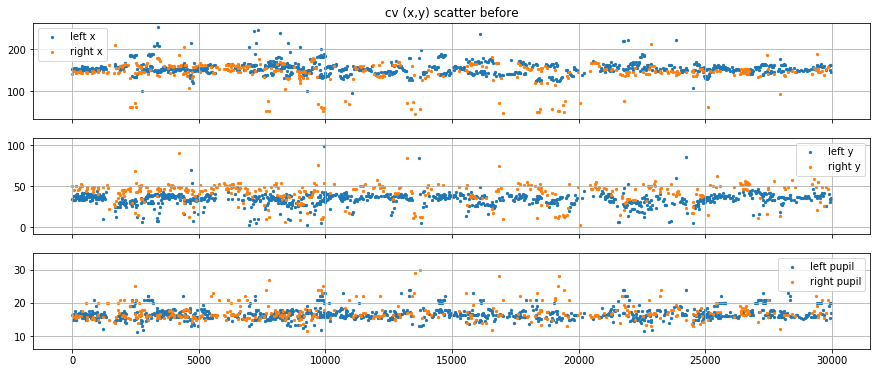

**medcouple 0.1
IQR 1.75 lower 13.9 Q1 15.75 Q3 17.5 upper 21.42
remove ratio  0.07126436781609191 

**medcouple 0.0
IQR 9.0 lower 5.5 Q1 32.5 Q3 41.5 upper 68.5
remove ratio  0.005775577557755818 

**medcouple 0.0
IQR 14.25 lower 103.5 Q1 146.25 Q3 160.5 upper 203.25
remove ratio  0.02904564315352698 

after clean data, remove ratio 0.10344827586206895


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


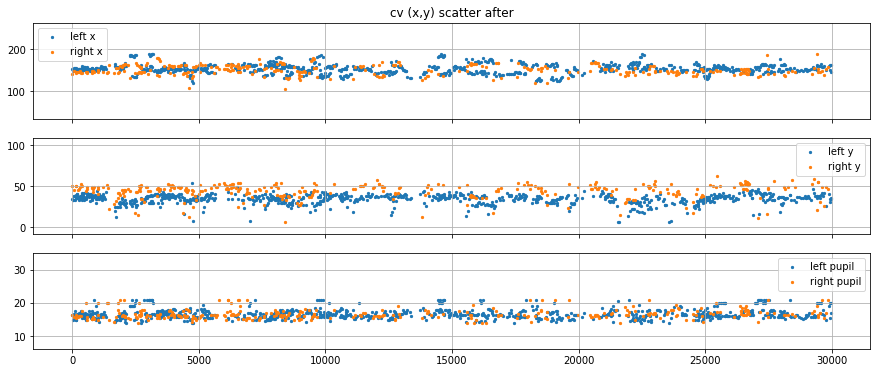

In [8]:
cv_38, s30_cv38, s31_cv38, s32_cv38 = input_data('train38')
run(cv_38)

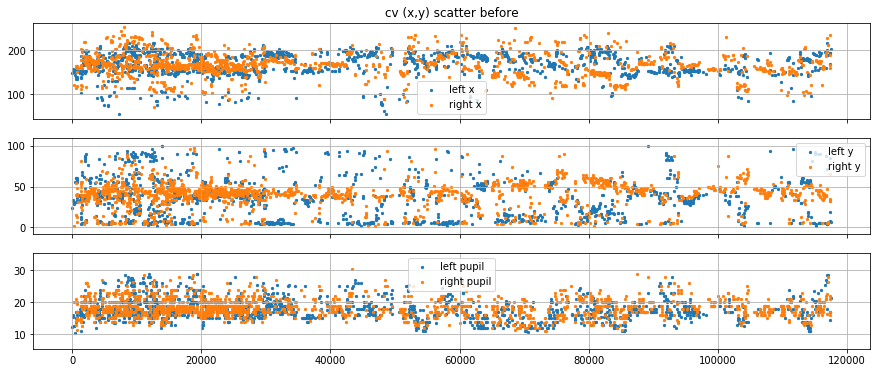

**medcouple 0.0
IQR 4.0 lower 10.0 Q1 16.0 Q3 20.0 upper 26.0
remove ratio  0.01632245169886737 

**medcouple -0.2
IQR 21.0 lower -112.21 Q1 28.0 Q3 49.0 upper 80.28
remove ratio  0.04436166610226888 

**medcouple 0.0
IQR 33.0 lower 54.0 Q1 153.0 Q3 186.0 upper 285.0
remove ratio  0.0 

after clean data, remove ratio 0.059960026648900766


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


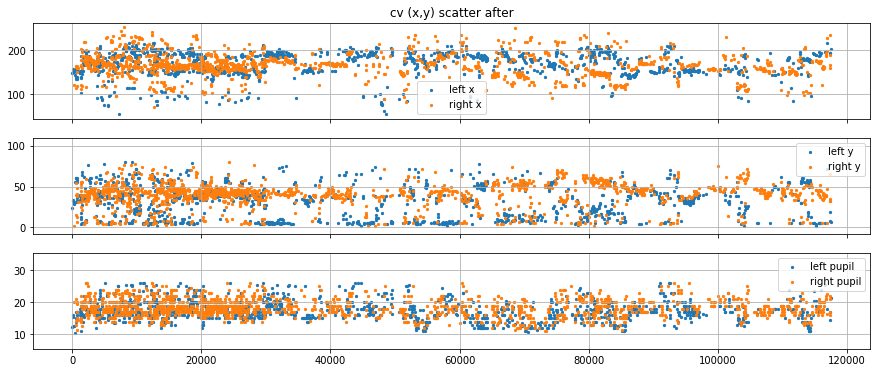

In [9]:
cv_1, s30_cv1, s31_cv1, s32_cv1 = input_data('train01')
run(cv_1)

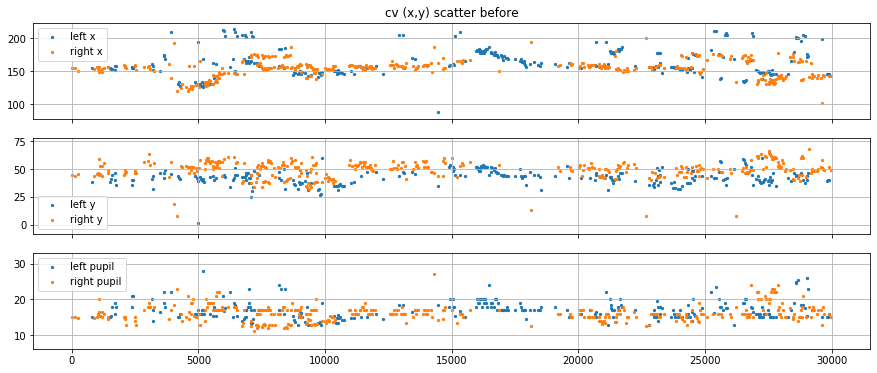

**medcouple 0.0
IQR 3.0 lower 10.5 Q1 15.0 Q3 18.0 upper 22.5
remove ratio  0.030399999999999983 

**medcouple 0.0
IQR 10.5 lower 10.0 Q1 41.5 Q3 52.0 upper 83.5
remove ratio  0.004950495049504955 

**medcouple 0.1
IQR 18.0 lower 109.95 Q1 148.0 Q3 166.0 upper 246.56
remove ratio  0.0033167495854062867 

after clean data, remove ratio 0.03839999999999999


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


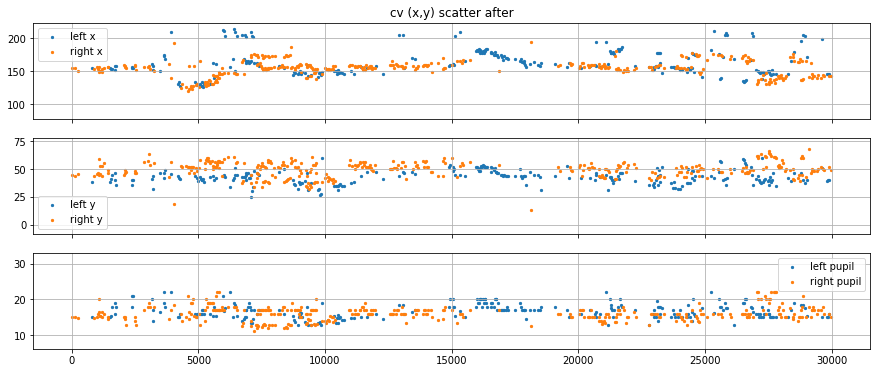

In [10]:
cv_2, s30_cv2, s31_cv2, s32_cv2 = input_data('train02')
run(cv_2)